In [1]:
libraries = c("dplyr","magrittr","tidyr","ggplot2","RColorBrewer","zoo","lubridate","tidyverse",
              "readxl","gridExtra","MASS","ggpubr", "mixdist", "MMWRweek")
for(x in libraries) {library(x, character.only=TRUE, warn.conflicts=FALSE, quietly=TRUE)}

theme_set(theme_bw())
version$version.string

options(scipen=10000)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats 1.0.0     ✔ stringr 1.5.1
✔ purrr   1.0.2     ✔ tibble  3.2.1
✔ readr   2.1.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract()   masks magrittr::extract()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ purrr::set_names() masks magrittr::set_names()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[1] "R version 4.3.2 (2023-10-31)"

# Time-varying vaccine effectivness

In [2]:
read.csv("../data/UK_HSA_VE2.csv") -> df_VE

## vaccine effectiveness of the 2nd dose against Delta
df_VE %>% filter(variant==c("Delta")) %>% mutate(value=value*0.01, day=t*7) %>% 
mutate(day=case_when(t==25 ~ 245, TRUE~day)) -> df_VE_non
as.data.frame(c(0)) -> temp; colnames(temp) <- c("t")
temp %<>% mutate(value=df_VE_non$value[1], variant=df_VE_non$variant[1], day=0)
rbind(temp, df_VE_non) -> df_VE_non

## vaccine effectiveness of the 2nd dose against Omicron
df_VE %>% filter(variant==c("Omicron")) %>% mutate(value=value*0.01, day=t*7) %>% 
mutate(day=case_when(t==25 ~ 245, TRUE~day)) -> df_VE_Omi
as.data.frame(c(0)) -> temp; colnames(temp) <- c("t")
temp %<>% mutate(value=df_VE_Omi$value[1], variant=df_VE_Omi$variant[1], day=0)
rbind(temp, df_VE_Omi) -> df_VE_Omi

## vaccine effectiveness of the booster dose against Delta
df_VE %>% filter(variant==c("Booster_Delta")) %>% mutate(value=value*0.01, day=t*7) %>% 
mutate(day=case_when(t==25 ~ 245, TRUE~day)) %>% filter(t >=3) -> df_VE_booster_delta
as.data.frame(c(0)) -> temp; colnames(temp) <- c("t")
temp %<>% mutate(value=df_VE_booster_delta$value[1], variant=df_VE_booster_delta$variant[1], day=0)
rbind(temp, df_VE_booster_delta) -> df_VE_booster_delta

## vaccine effectiveness of the booster dose against Omicron
df_VE %>% filter(variant==c("Booster")) %>% mutate(value=value*0.01, day=t*7) %>% 
mutate(day=case_when(t==25 ~ 245, TRUE~day)) %>% filter(t >=3) -> df_VE_booster
as.data.frame(c(0)) -> temp; colnames(temp) <- c("t")
temp %<>% mutate(value=df_VE_booster$value[1], variant=df_VE_booster$variant[1], day=0)
rbind(temp, df_VE_booster) -> df_VE_booster

In [3]:
## time gap between the vaccination and immune response
vac_gap <- 14

## maximum and minimum points of the natural infection
max_DeltaInf <- 1; min_DeltaInf <- 0.6;
max_OmicronInf <- 1; min_OmicronInf <- 0.6

## maximum and minimum points of the VE
max_Delta <- 0.95; min_Delta <- 0.6
max_Delta_boost <- 0.95; min_Delta_boost <- 0.6
max_Omicron <- 0.7; min_Omicron <- 0.15
max_Omicron_boost <- 0.75; min_Omicron_boost <- 0.15

In [4]:
## estimating the rate of exponential distribution (Delta)
as.data.frame(c(0:max(df_VE_non$day))) -> temp; colnames(temp) <- c("day")
merge(temp, df_VE_non %>% filter(day>0) %>% mutate(value=value*100), by=c("day"), all.x=TRUE) -> df_VE_non_llk
df_VE_non_llk$variant[is.na(df_VE_non_llk$variant)] <- c("Delta")

comibned_llk <- function(params){
    
    modeled <- rep(0, nrow(df_VE_non_llk)); llk1 <- rep(0, nrow(df_VE_non_llk))
    
    for(i in 0:max(df_VE_non_llk$day)){
        modeled[i+vac_gap+1] <- ((max_Delta-min_Delta)*exp(-params[1]*i)+min_Delta)*100
        llk1[i+1] <- -(-modeled[i+vac_gap+1]+df_VE_non_llk$value[i+1]*log(modeled[i+vac_gap+1])-lgamma(df_VE_non_llk$value[i+1]+1))
    }
    
    llk1[is.na(llk1)] <- 0


    ## estimating the rate of exponential distribution (Omicron)
    as.data.frame(c(0:max(df_VE_Omi$day))) -> temp; colnames(temp) <- c("day")
    merge(temp, df_VE_Omi %>% filter(day>0) %>% mutate(value=value*100), by=c("day"), all.x=TRUE) -> df_VE_Omi_llk
    df_VE_Omi_llk$variant[is.na(df_VE_Omi_llk$variant)] <- c("Omicron")
    
    modeled <- rep(0, nrow(df_VE_Omi_llk)); llk2 <- rep(0, nrow(df_VE_Omi_llk))
    
    for(i in 0:max(df_VE_Omi_llk$day)){
        modeled[i+vac_gap+1] <- ((max_Omicron-min_Omicron)*exp(-params[2]*i)+min_Omicron)*100
        llk2[i+1] <- -(-modeled[i+vac_gap+1]+df_VE_Omi_llk$value[i+1]*log(modeled[i+vac_gap+1])-lgamma(df_VE_Omi_llk$value[i+1]+1))
    }
    
    llk2[is.na(llk2)] <- 0


    ## estimating the rate of exponential distribution (Booster)
    as.data.frame(c(0:max(df_VE_booster$day))) -> temp; colnames(temp) <- c("day")
    merge(temp, df_VE_booster %>% filter(day>0) %>% mutate(value=value*100), by=c("day"), all.x=TRUE) -> df_VE_booster_llk
    df_VE_booster_llk$variant[is.na(df_VE_booster_llk$variant)] <- c("Booster")

    
    modeled <- rep(0, nrow(df_VE_booster_llk)); llk3 <- rep(0, nrow(df_VE_booster_llk))
    
    for(i in 0:max(df_VE_booster_llk$day)){
        modeled[i+vac_gap+1] <- ((max_Omicron_boost-min_Omicron_boost)*exp(-params[3]*i)+min_Omicron_boost)*100
        llk3[i+1] <- -(-modeled[i+vac_gap+1]+df_VE_booster_llk$value[i+1]*log(modeled[i+vac_gap+1])-lgamma(df_VE_booster_llk$value[i+1]+1))
    }
    
    llk3[is.na(llk3)] <- 0
    return(sum(llk1) + sum(llk2) + sum(llk3))
}


est_all <- optim(rep(0.01,3), fn=comibned_llk, method='BFGS', control=list(maxit=100000), hessian=TRUE)
est_all$par[1] -> w_rate; est_all$par[2] -> w_rate2; est_all$par[3] -> w_rate3

In [5]:
#### 95% confidence intervals using Hessian matrix
niter = 10000

library(MASS)

hes_p <- est_all$hessian
fisher_info<-solve(hes_p)

est_rate_sample <- mvrnorm(n=niter, mu=est_all$par, Sigma=fisher_info, tol=1e-25, empirical=FALSE, EISPACK=FALSE)
colnames(est_rate_sample) <- c("rate_non", "rate_omi", "rate_booster")

In [6]:
Delta_vax_list <- list(); Delta_inf_list <- list()
Omicron_vax_list <- list(); Omicron_booster_list <- list(); Omicron_inf_list <- list()

for(i in 1:niter){
    as.matrix((max_Delta-min_Delta)*exp(-est_rate_sample[i,1]*c(0:500))+min_Delta) -> Delta_vax_list[[i]]
    as.matrix((max_DeltaInf-min_DeltaInf)*exp(-est_rate_sample[i,1]*c(0:500))+min_DeltaInf) -> Delta_inf_list[[i]]
    
    as.matrix((max_Omicron-min_Omicron)*exp(-est_rate_sample[i,2]*c(0:500))+min_Omicron) -> Omicron_vax_list[[i]]
    as.matrix((max_Omicron_boost-min_Omicron_boost)*exp(-est_rate_sample[i,3]*c(0:500))+min_Omicron_boost) -> Omicron_booster_list[[i]]
    as.matrix((max_OmicronInf-min_OmicronInf)*exp(-est_rate_sample[i,1]*c(0:500))+min_OmicronInf) -> Omicron_inf_list[[i]]
}

do.call(cbind, Delta_vax_list) -> Delta_vax; do.call(cbind, Delta_inf_list) -> Delta_inf
do.call(cbind, Omicron_vax_list) -> Omicron_vax; do.call(cbind, Omicron_booster_list) -> Omicron_booster
do.call(cbind, Omicron_inf_list) -> Omicron_inf 

In [7]:
Delta_vax_CI <- matrix(NA, ncol=3, nrow=nrow(Delta_vax));
Delta_inf_CI <- matrix(NA, ncol=3, nrow=nrow(Delta_inf));

for(k in 1:nrow(Delta_vax)){
    quantile(unlist(Delta_vax[k,]), 0.025) -> Delta_vax_CI[k,1]
    quantile(unlist(Delta_vax[k,]), 0.5) -> Delta_vax_CI[k,2]
    quantile(unlist(Delta_vax[k,]), 0.975) -> Delta_vax_CI[k,3]}

Delta_vax_CI %>% as.data.frame() %>% mutate(day=(0:500)+vac_gap, group=c("1st & 2nd dose")) -> merged
colnames(merged) <- c("lower", "median", "upper", "day", "group")

for(k in 1:nrow(Delta_inf)){
    quantile(unlist(Delta_inf[k,]), 0.025) -> Delta_inf_CI[k,1]
    quantile(unlist(Delta_inf[k,]), 0.5) -> Delta_inf_CI[k,2]
    quantile(unlist(Delta_inf[k,]), 0.975) -> Delta_inf_CI[k,3]}

Delta_inf_CI %>% as.data.frame() %>% mutate(day=(0:500), group=c("Infection")) -> merged2
colnames(merged2) <- c("lower", "median", "upper", "day", "group")

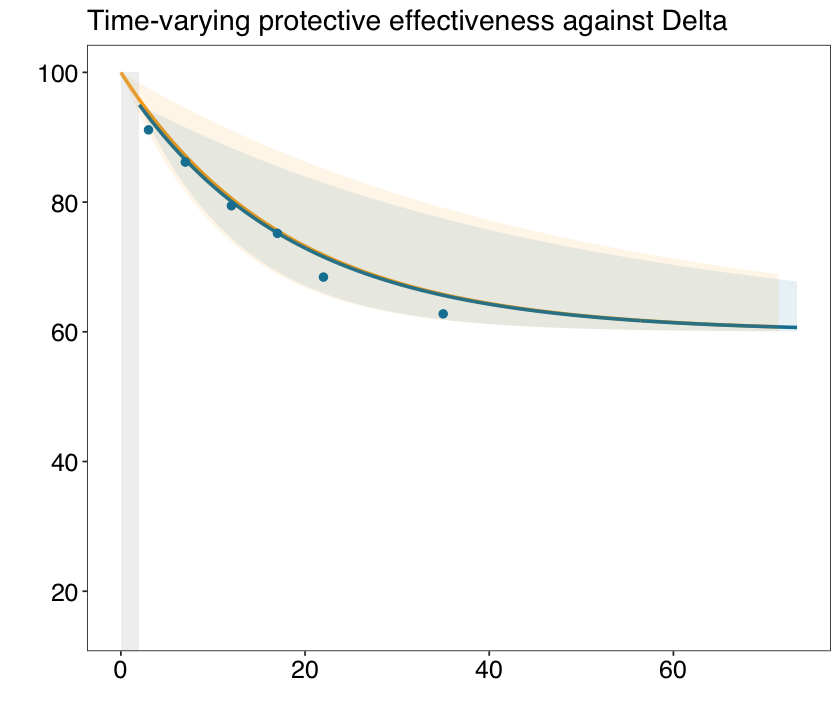

In [8]:
## figures for the modeled vaccine effectivness against infection with Delta
merged %>% dplyr::select("median", "day", "group") -> temp1
merged2 %>% dplyr::select("median", "day", "group") -> temp2
as.data.frame(rep(0,501)) %>% mutate(day=0:500, group=c("3rd dose")) -> temp3
colnames(temp3) <- c("median", "day", "group")

rbind(temp1, temp2, temp3) -> temp_all
temp_all$group <- factor(temp_all$group,levels = c("Infection","1st & 2nd dose", "3rd dose"))

options(repr.plot.width=7,repr.plot.height=6)
temp_all %>% filter(day <= 525) %>%
    ggplot() + 
    geom_line(aes(x=day/7, y=median*100, group=group, colour=group),linewidth=1) +
    geom_ribbon(data=merged2, aes(x=day/7, ymax=upper*100, ymin=lower*100), fill="#FAAB18", alpha = 0.1) +
    geom_ribbon(data=merged, aes(x=day/7, ymax=upper*100, ymin=lower*100), fill="#1380A1", alpha = 0.1) +
    geom_point(data=df_VE_non %>% filter(day>0), aes(x=day/7, y=value*100), color="#1380A1", size=2) +
    scale_colour_manual("",  values = c("1st & 2nd dose"="#1380A1", "3rd dose"="#990000", "Infection"="#FAAB18")) +
    ggtitle("Time-varying protective effectiveness against Delta") +
    labs(x="\n Weeks since vaccination or infection", y="Protective effectiveness (%) \n") +
    labs(x="", y="") +
    theme(text = element_text(size=15, family="sans",color="black"),
          axis.text = element_text(size=15, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          legend.title = element_text(size = 15),
          legend.text = element_text(size = 15),
          legend.position="none",
          plot.title = element_text(size=17, family="sans",color="black")) +
    scale_y_continuous(breaks=c(20,40,60,80,100)) +
    annotate("rect", xmin = 0, xmax = 2, ymin = 0, ymax = 100, alpha = 0.2, fill = "grey70") +
    coord_cartesian(ylim = c(15,100)) -> VE_Delta_figure

readRDS("VE_Omicron.rds") -> VE_Omicron_figure
VE_Delta_figure

In [9]:
Omicron_vax_CI <- matrix(NA, ncol=3, nrow=nrow(Omicron_vax));
Omicron_booster_CI <- matrix(NA, ncol=3, nrow=nrow(Omicron_booster));
Omicron_inf_CI <- matrix(NA, ncol=3, nrow=nrow(Omicron_inf));

for(k in 1:nrow(Omicron_vax)){
    quantile(unlist(Omicron_vax[k,]), 0.025) -> Omicron_vax_CI[k,1]
    quantile(unlist(Omicron_vax[k,]), 0.5) -> Omicron_vax_CI[k,2]
    quantile(unlist(Omicron_vax[k,]), 0.975) -> Omicron_vax_CI[k,3]}

Omicron_vax_CI %>% as.data.frame() %>% mutate(day=(0:500)+vac_gap, group=c("1st & 2nd dose")) -> merged
colnames(merged) <- c("lower", "median", "upper", "day", "group")

for(k in 1:nrow(Omicron_booster)){
    quantile(unlist(Omicron_booster[k,]), 0.025) -> Omicron_booster_CI[k,1]
    quantile(unlist(Omicron_booster[k,]), 0.5) -> Omicron_booster_CI[k,2]
    quantile(unlist(Omicron_booster[k,]), 0.975) -> Omicron_booster_CI[k,3]}

Omicron_booster_CI %>% as.data.frame() %>% mutate(day=(0:500)+vac_gap, group=c("1st booster")) -> merged2
colnames(merged2) <- c("lower", "median", "upper", "day", "group")

for(k in 1:nrow(Omicron_inf)){
    quantile(unlist(Omicron_inf[k,]), 0.025) -> Omicron_inf_CI[k,1]
    quantile(unlist(Omicron_inf[k,]), 0.5) -> Omicron_inf_CI[k,2]
    quantile(unlist(Omicron_inf[k,]), 0.975) -> Omicron_inf_CI[k,3]}

Omicron_inf_CI %>% as.data.frame() %>% mutate(day=(0:500), group=c("Infection")) -> merged3
colnames(merged3) <- c("lower", "median", "upper", "day", "group")

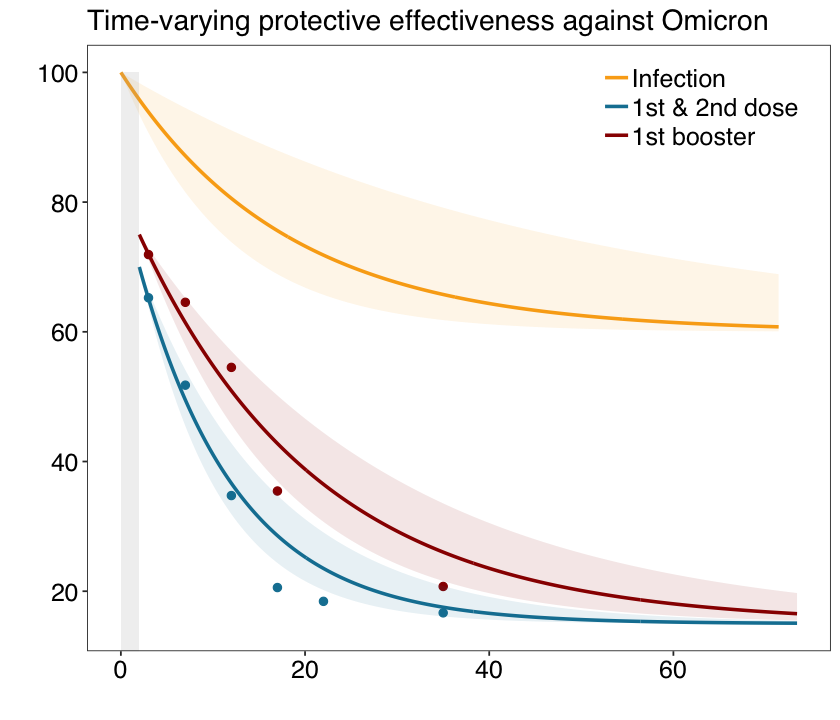

In [10]:
## figures for the modeled vaccine effectivness against infection with Delta
merged %>% dplyr::select("median", "day", "group") -> temp1
merged2 %>% dplyr::select("median", "day", "group") -> temp2
merged3 %>% dplyr::select("median", "day", "group") -> temp3

rbind(temp1, temp2, temp3) -> temp_all
temp_all$group <- factor(temp_all$group,levels = c("Infection","1st & 2nd dose", "1st booster"))
       
options(repr.plot.width=7,repr.plot.height=6)
temp_all %>% filter(day <= 525) %>%
    ggplot() + 
    geom_line(aes(x=day/7, y=median*100, group=group, colour=group),linewidth=1) +
    geom_point(data=df_VE_Omi %>% filter(day>0), aes(x=day/7, y=value*100), color="#1380A1", size=2) +
    geom_point(data=df_VE_booster %>% filter(day>0), aes(x=day/7, y=value*100), color="#990000", size=2) +
    geom_ribbon(data=merged, aes(x=day/7, ymax=upper*100, ymin=lower*100), fill="#1380A1", alpha = 0.1) +
    geom_ribbon(data=merged2, aes(x=day/7, ymax=upper*100, ymin=lower*100), fill="#990000", alpha = 0.1) +
    geom_ribbon(data=merged3, aes(x=day/7, ymax=upper*100, ymin=lower*100), fill="#FAAB18", alpha = 0.1) +
    scale_colour_manual("",  values = c("1st & 2nd dose"="#1380A1", "1st booster"="#990000", "Infection"="#FAAB18")) +
    ggtitle("Time-varying protective effectiveness against Omicron") +
    labs(x="\n Weeks since vaccination or infection", y="Protective effectiveness (%) \n") +
    labs(x="", y="") +
    theme(text = element_text(size=15, family="sans",color="black"),
          axis.text = element_text(size=15, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          legend.title = element_text(size = 1),
          legend.text = element_text(size = 15),
          plot.title = element_text(size=17, family="sans",color="black"),
          legend.position = c(.97, .99),
          legend.justification = c("right", "top"), legend.box.just = "right", legend.margin = margin(6, 6, 6, 6)) +
    scale_y_continuous(breaks=c(20,40,60,80,100)) +
    annotate("rect", xmin = 0, xmax = 2, ymin = 0, ymax = 100, alpha = 0.2, fill = "grey70") +
    coord_cartesian(ylim = c(15,100)) -> VE_Omicron_figure

saveRDS(VE_Omicron_figure, "VE_Omicron.rds")
VE_Omicron_figure

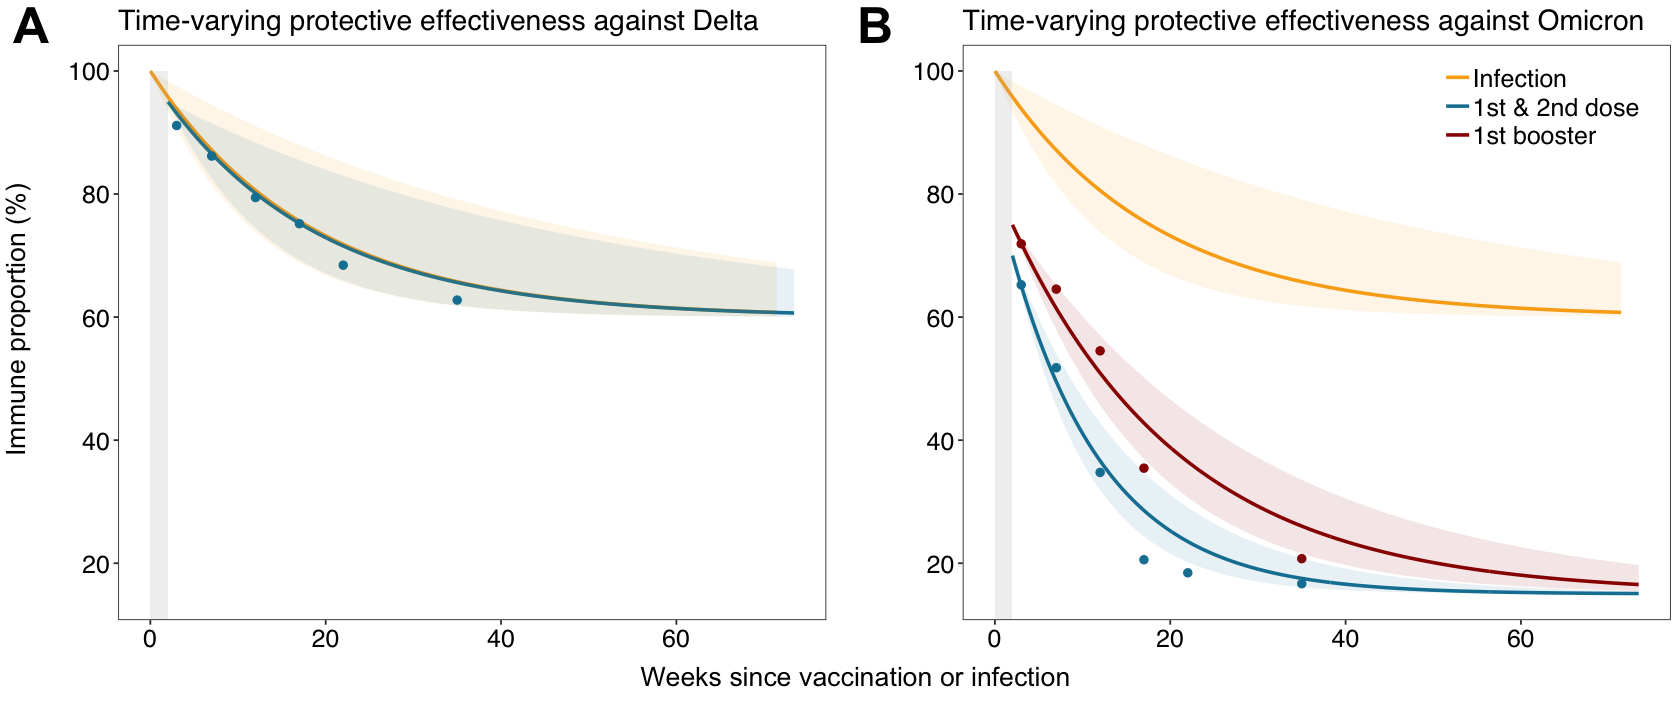

In [11]:
options(repr.plot.width=14,repr.plot.height=6)
ggarrange(VE_Delta_figure, ggplot() + theme_void(), VE_Omicron_figure, nrow=1, widths = c(1, 0.05, 1), 
          labels = c("A", "", "B"), font.label = list(size = 30), vjust=1.2, hjust=0.5) -> Fig_VE

annotate_figure(Fig_VE, 
                left=text_grob("Immune proportion (%)", size=16, rot=90, hjust=0.35),
                bottom=text_grob("Weeks since vaccination or infection", size=16, vjust=-1)) -> Fig_VE_combined
Fig_VE_combined

saveRDS(Fig_VE_combined, "Fig_VE_combined.rds")
ggsave("../figures/Final figures/Fig_S1.png", width = 14, height = 6, dpi=300, bg="white")

# Time-varying immune proportion

## (1) Number of newly vaccinated individuals

In [12]:
popsize <- c(8514274, 13431836, 16792282, 12923898)

In [13]:
## data for the WEEKLY number of allocated vaccines by dose
readRDS("vax_df.rds") -> vax_df

vax_df %>% mutate(sum_vac=mRNA+JJ+AZ+Cross) %>% group_by(date, order, age_group) %>% 
mutate(allsum_vac = cumsum(sum_vac)) %>% group_by(date, order, age_group) %>% 
summarize(maxsum_vac = max(allsum_vac)) %>% ungroup %>%
group_by(order) %>% mutate(cum_vac=cumsum(maxsum_vac)) %>% ungroup %>%
group_by(date, order) %>% summarize(final_vac = max(cum_vac)/sum(popsize)) %>% filter(order<=3) %>% 
mutate(dose=case_when(order==1 ~ c("1st dose"), order==2 ~ ("2nd dose"), order==3 ~ ("3rd dose"))) %>%
mutate(final_vac_per=final_vac*100) %>% ungroup() -> df_vaccov


## converting to the DAILY number of allocated vaccines by dose
df_vaccov %>% group_by(order) %>% mutate(cum_vac=final_vac*sum(popsize)) %>% 
mutate(year=MMWRweek(date)$MMWRyear, week=MMWRweek(date)$MMWRweek) -> week_df_vaccov

as.data.frame(seq(as.Date("2021-03-07"), max(df_vaccov$date), 1)) -> cal_daily; colnames(cal_daily) <- c("date")
cal_daily %<>% mutate(year=MMWRweek(date)$MMWRyear, week=MMWRweek(date)$MMWRweek)

merge(cal_daily, week_df_vaccov %>% filter(order==1), by=c("date", "year", "week"), all=TRUE) -> day_temp
day_temp %>% mutate(order=unique(na.omit(day_temp)$order), 
                    cum_vac=approx(day_temp$date, day_temp$cum_vac, xout=date, method="linear")$y,
                    final_vac=approx(day_temp$date, day_temp$final_vac, xout=date, method="linear")$y) %>%
dplyr::select(date, year, week, order, final_vac, cum_vac) %>%
mutate(new_vac=cum_vac-lag(cum_vac, default=0)) %>% mutate(adj_date = date+vac_gap) -> df_vaccov1

merge(cal_daily, week_df_vaccov %>% filter(order==2), by=c("date", "year", "week"), all=TRUE) -> day_temp
day_temp %>% mutate(order=unique(na.omit(day_temp)$order), 
                    cum_vac=approx(day_temp$date, day_temp$cum_vac, xout=date, method="linear")$y,
                    final_vac=approx(day_temp$date, day_temp$final_vac, xout=date, method="linear")$y) %>%
dplyr::select(date, year, week, order, final_vac, cum_vac) %>%
mutate(new_vac=cum_vac-lag(cum_vac, default=0)) %>% mutate(adj_date = date+vac_gap) -> df_vaccov2

merge(cal_daily, week_df_vaccov %>% filter(order==3), by=c("date", "year", "week"), all=TRUE) -> day_temp
day_temp %>% mutate(order=unique(na.omit(day_temp)$order), 
                    cum_vac=approx(day_temp$date, day_temp$cum_vac, xout=date, method="linear")$y,
                    final_vac=approx(day_temp$date, day_temp$final_vac, xout=date, method="linear")$y) %>%
dplyr::select(date, year, week, order, final_vac, cum_vac) %>%
mutate(new_vac=cum_vac-lag(cum_vac, default=0)) %>% mutate(adj_date = date+vac_gap) -> df_vaccov3


## Start from the start
as.data.frame(seq(as.Date("2020-01-15"), (min(df_vaccov3$date)-1), 1)) %>%
mutate(year=NA, week=NA, order=NA, final_vac=NA, cum_vac=1e-9, new_vac=0) -> temp
colnames(temp) <- c("date", "year", "week", "order", 'final_vac', "cum_vac", "new_vac")
temp %<>% mutate(adj_date=date+vac_gap)

rbind(temp, df_vaccov1) %>% as.data.frame() %>% arrange(date) -> df_vaccov1
rbind(temp, df_vaccov2) %>% as.data.frame() %>% arrange(date) -> df_vaccov2
rbind(temp, df_vaccov3) %>% as.data.frame() %>% arrange(date) -> df_vaccov3

`summarise()` has grouped output by 'date', 'order'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'date'. You can override using the
`.groups` argument.


## (2) Incidence

## (2-1) Number of newly confirmed cases with Delta

In [14]:
readRDS("backproj_cases_non_Omi_MA.rds") -> backproj_Delta
backproj_Delta %>% 
filter(onset >= as.Date("2020-01-15") & onset < as.Date("2022-01-01")) %>% rename(date=onset) -> case_Delta_conv

## (2-2) Number of newly confirmed cases with all SARS-CoV-2

In [15]:
readRDS("backproj_cases_non_Omi_MA.rds") -> backproj_Delta
readRDS("backproj_cases_Omi_MA.rds") -> backproj_Omicron

backproj_Delta %>% filter(onset >= as.Date("2020-01-15") & onset < as.Date("2022-07-01")) %>% 
rename(date=onset) -> case_Delta_conv2
backproj_Omicron %>% filter(onset >= as.Date("2020-01-15") & onset < as.Date("2022-07-01")) %>% 
rename(date=onset) -> case_Omicron_conv

In [16]:
## case ascertainment rate
k=0.66 ## borrowed from Korean serosurvey study (Han, et al. EpiH, 2022)
SD=0.01
as.matrix(rnorm(niter, k, SD)) -> random_ascertain; colnames(random_ascertain) <- c("k")

In [17]:
cbind(est_rate_sample, random_ascertain) -> sample_set

# Time-varying immune proportion in Delta period

In [18]:
################################### DELETE
niter=1000
################################### DELETE

In [19]:
library(foreach); library(doParallel);
(ncore <- detectCores(logical = FALSE))


Attaching package: 'foreach'


The following objects are masked from 'package:purrr':

    accumulate, when


Loading required package: iterators

Loading required package: parallel



[1] 8

In [20]:
myCluster <- makeCluster(ncore-1, type = "PSOCK")
registerDoParallel(myCluster)

vac_abs <- numeric(nrow(case_Delta_conv))
immune_vac <- numeric(nrow(case_Delta_conv))
immune_inf <- numeric(nrow(case_Delta_conv))

immune_total_Delta <- vector("list", niter)
immune_vac_Delta <- vector("list", niter)
immune_inf_Delta <- vector("list", niter)

parallel_prop_list <- list()
parallel_prop_list <- foreach (i = 1:niter) %dopar% {
    
    sample_set_exp <- exp(-sample_set[i,1] * c(0:750))
    delta_exp <- (max_Delta - min_Delta) * sample_set_exp + min_Delta
    delta_inf_exp <- (max_DeltaInf - min_DeltaInf) * sample_set_exp + min_DeltaInf
    
    for (Time in 3:nrow(case_Delta_conv)) {
        conv1 <- numeric(Time); conv2 <- numeric(Time); conv3 <- numeric(Time); conv_inf <- numeric(Time)
    
    for (t in 2:(Time - 1)) {
      inf_waned <- rep(0, t)
        for (tau in 1:(t - 1)) {
            inf_waned[tau] <- case_Delta_conv$total[tau] * delta_inf_exp[t - tau]}

        conv1[t] <- df_vaccov1$new_vac[t] * (1 - df_vaccov2$cum_vac[Time] / df_vaccov1$cum_vac[Time]) *
        (1 - sum(inf_waned) / sum(popsize)) * delta_exp[Time - t]

        conv2[t] <- df_vaccov2$new_vac[t] * (1 - df_vaccov3$cum_vac[Time] / df_vaccov2$cum_vac[Time]) *
        (1 - sum(inf_waned) / sum(popsize)) * delta_exp[Time - t]

        conv3[t] <- df_vaccov3$new_vac[t] * (1 - sum(inf_waned) / sum(popsize)) * delta_exp[Time - t]
        
        conv_inf[t] <- case_Delta_conv$total[t]/sample_set[i,4] * delta_inf_exp[Time - t]}
        
        vac_abs[Time] <- sum(conv1) + sum(conv2) + sum(conv3) + sum(conv_inf)
    }
    parallel_prop_list[[i]] <- as.matrix(vac_abs)
}

stopCluster(myCluster)

do.call(cbind, parallel_prop_list) -> immune_total_Delta

saveRDS(immune_total_Delta, "RDS/immune_total_Delta.RDS")

In [18]:
readRDS("RDS/immune_total_Delta.RDS") -> immune_total_Delta
immune_total_Delta/sum(popsize) -> temp; temp %>% as.data.frame() %>%
mutate(t=0:(nrow(case_Delta_conv)-1)) %>% mutate(date=t+min(case_Delta_conv$date)) -> immune_total_Delta_dt

saveRDS(immune_total_Delta_dt, "RDS/immune_total_Delta_wDate.RDS")

In [19]:
immune_total_Delta_CI <- matrix(NA, nrow=nrow(immune_total_Delta), ncol=3)
                                
for(k in 1:nrow(immune_total_Delta)){
    quantile(immune_total_Delta[k,], 0.025) -> immune_total_Delta_CI[k,1]
    quantile(immune_total_Delta[k,], 0.5) -> immune_total_Delta_CI[k,2]
    quantile(immune_total_Delta[k,], 0.975) -> immune_total_Delta_CI[k,3]}

immune_total_Delta_CI/sum(popsize) -> temp; temp %>% as.data.frame() %>%
mutate(t=0:(nrow(case_Delta_conv)-1)) %>% mutate(date=t+min(case_Delta_conv$date), dose=c("Immuned")) %>%
rename(lower=V1, median=V2, upper=V3) -> immune_fig

immune_fig %>% tail()

,lower,median,upper,t,date,dose
,<dbl>,<dbl>,<dbl>,<int>,<date>,<chr>
712,0.6601132,0.6964030,0.7649197,711,2021-12-26,Immuned
713,0.6612173,0.6974242,0.7657814,712,2021-12-27,Immuned
714,0.6623150,0.6984426,0.7666401,713,2021-12-28,Immuned
715,0.6634068,0.6994588,0.7674964,714,2021-12-29,Immuned
716,0.6644930,0.7004730,0.7683506,715,2021-12-30,Immuned
717,0.6655736,0.7014852,0.7692028,716,2021-12-31,Immuned


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


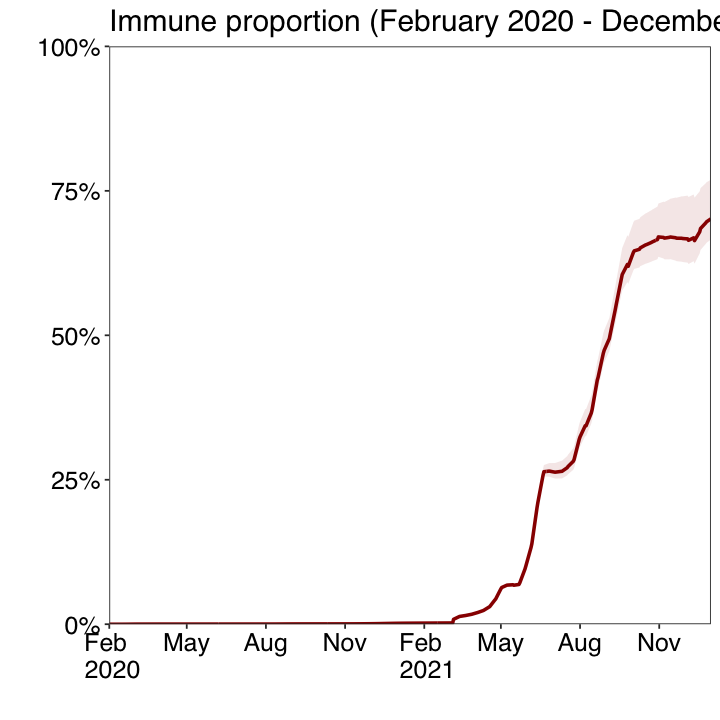

In [20]:
options(repr.plot.width=6,repr.plot.height=6)
immune_fig %>% filter(date >= as.Date("2020-02-01") & date <= as.Date("2022-01-01")) %>%
ggplot() + 
geom_line(aes(x=date, y=median), color="#990000", size=1) +
geom_ribbon(aes(x=date, ymax=upper, ymin=lower), fill="#990000", alpha = 0.1) +
ggtitle("Immune proportion (February 2020 - December 2021)") +
labs(x="\n Date", y="Proportion (%) \n") +
labs(x="", y="") +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 15),
      legend.text = element_text(size = 15),
      plot.title = element_text(size=18, family="sans",color="black")) +
scale_y_continuous(expand = c(0, 0), labels = scales::percent_format(accuracy = 1)) +
coord_cartesian(ylim = c(0,1)) +
 scale_x_date(date_breaks = "3 months", expand = c(0, 0),
              labels = function(x) if_else(is.na(lag(x)) | !year(lag(x)) == year(x), 
                                           paste(month(x, label = TRUE), "\n", year(x)), 
                                           paste(month(x, label = TRUE)))) -> fig_immune1
              
fig_immune1

# Time-varying immune proportion in Omicron period

In [ ]:
myCluster <- makeCluster(ncore-1, type = "PSOCK")
registerDoParallel(myCluster)

vac_abs <- numeric(nrow(case_Omicron_conv))
immune_total_Omicron <- vector("list", niter)

parallel_prop_list2 <- list()
parallel_prop_list2 <- foreach (i = 1:niter) %dopar% {
    
    sample_set_exp <- exp(-sample_set[i,1] * c(0:900))
    sample_set_exp2 <- exp(-sample_set[i,2] * c(0:900))
    sample_set_exp3 <- exp(-sample_set[i,3] * c(0:900))
    omicron_exp <- (max_Omicron - min_Omicron) * sample_set_exp2 + min_Omicron
    omicron_exp2 <- (max_OmicronInf - min_OmicronInf) * sample_set_exp + min_OmicronInf
    omicron_exp3 <- (max_Omicron_boost - min_Omicron_boost) * sample_set_exp3 + min_Omicron_boost
    
    for (Time in 3:nrow(case_Omicron_conv)) {
        conv1 <- numeric(Time); conv2 <- numeric(Time); conv3 <- numeric(Time); 
        conv_Delta <- numeric(Time); conv_Omicron <- numeric(Time);

    for (t in 2:(Time - 1)) {
      inf_waned <- rep(0, t); inf_waned2 <- rep(0, t)
        for (tau in 1:(t - 1)) {
            inf_waned[tau] <- case_Delta_conv2$total[tau]/sample_set[i,4] * omicron_exp[t - tau]
            inf_waned2[tau] <- case_Omicron_conv$total[tau]/sample_set[i,4] * omicron_exp2[t - tau]}
    
        conv1[t] <- df_vaccov1$new_vac[t] * (1 - df_vaccov2$cum_vac[Time] / df_vaccov1$cum_vac[Time]) *
        (1 - (sum(inf_waned)+sum(inf_waned2)) / sum(popsize)) * omicron_exp[Time - t]

        conv2[t] <- df_vaccov2$new_vac[t] * (1 - df_vaccov3$cum_vac[Time] / df_vaccov2$cum_vac[Time]) *
        (1 - (sum(inf_waned)+sum(inf_waned2)) / sum(popsize)) * omicron_exp[Time - t]

        conv3[t] <- df_vaccov3$new_vac[t] * (1 - (sum(inf_waned)+sum(inf_waned2)) / sum(popsize)) * 
        omicron_exp3[Time - t]
        
        conv_Delta[t] <- case_Delta_conv2$total[t]/sample_set[i,4] * omicron_exp[Time - t]
        
        conv_Omicron[t] <- case_Omicron_conv$total[t]/sample_set[i,4] * omicron_exp2[Time - t]}
        
        vac_abs[Time] <- sum(conv1) + sum(conv2) + sum(conv3) + sum(conv_Delta) + sum(conv_Omicron)    
    }
    parallel_prop_list2[[i]] <- as.matrix(vac_abs)
}

stopCluster(myCluster)

do.call(cbind, parallel_prop_list2) -> immune_total_Omicron

saveRDS(immune_total_Omicron, "RDS/immune_total_Omi.RDS")

In [21]:
readRDS("RDS/immune_total_Omi.RDS") -> immune_total_Omi
immune_total_Omi/sum(popsize) -> temp; temp %>% as.data.frame() %>%
mutate(t=0:(nrow(case_Omicron_conv)-1)) %>% mutate(date=t+min(case_Delta_conv$date)) -> immune_total_Omi_dt

saveRDS(immune_total_Omi_dt, "RDS/immune_total_Omi_wDate.RDS")

In [22]:
immune_total_Omi_CI <- matrix(NA, nrow=nrow(immune_total_Omi), ncol=3)
                                
for(k in 1:nrow(immune_total_Omi)){
    quantile(immune_total_Omi[k,], 0.025) -> immune_total_Omi_CI[k,1]
    quantile(immune_total_Omi[k,], 0.5) -> immune_total_Omi_CI[k,2]
    quantile(immune_total_Omi[k,], 0.975) -> immune_total_Omi_CI[k,3]}

immune_total_Omi_CI/sum(popsize) -> temp; temp %>% as.data.frame() %>%
mutate(t=0:(nrow(case_Omicron_conv)-1)) %>% mutate(date=t+min(case_Delta_conv$date), dose=c("Immuned")) %>%
rename(lower=V1, median=V2, upper=V3) -> immune_fig2

immune_fig2 %>% tail()

,lower,median,upper,t,date,dose
,<dbl>,<dbl>,<dbl>,<int>,<date>,<chr>
893,0.6004030,0.6580678,0.7373340,892,2022-06-25,Immuned
894,0.5990282,0.6566840,0.7361055,893,2022-06-26,Immuned
895,0.5976639,0.6552414,0.7348797,894,2022-06-27,Immuned
896,0.5963012,0.6538674,0.7336476,895,2022-06-28,Immuned
897,0.5949313,0.6525343,0.7323999,896,2022-06-29,Immuned
898,0.5935468,0.6511669,0.7310679,897,2022-06-30,Immuned


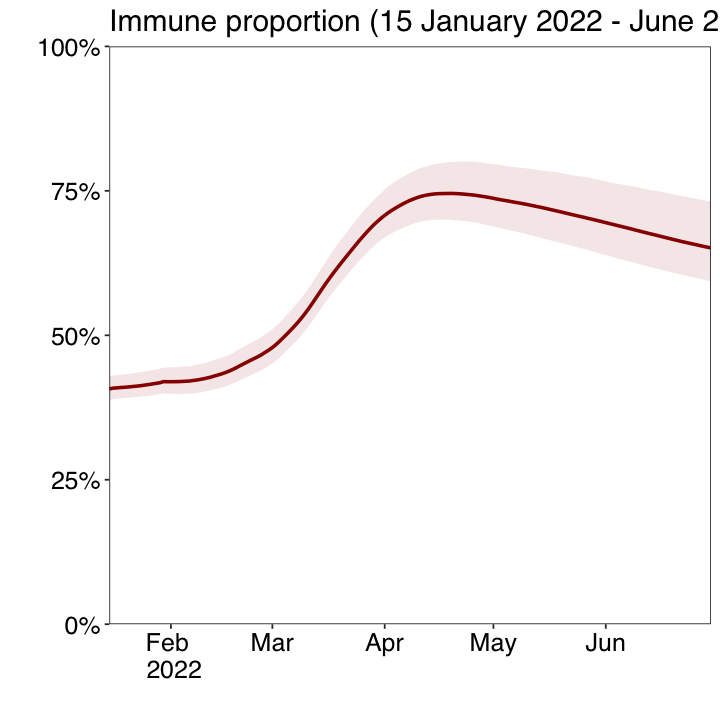

In [23]:
options(repr.plot.width=6,repr.plot.height=6)
immune_fig2 %>% filter(date >= as.Date("2022-01-15")) %>%
ggplot() + 
geom_line(aes(x=date, y=median), color="#990000", size=1) +
geom_ribbon(aes(x=date, ymax=upper, ymin=lower), fill="#990000", alpha = 0.1) +
ggtitle("Immune proportion (15 January 2022 - June 2022)") +
labs(x="\n Date", y="Proportion (%) \n") +
labs(x="", y="") +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 15),
      legend.text = element_text(size = 15),
      plot.title = element_text(size=18, family="sans",color="black")) +
scale_y_continuous(expand = c(0, 0), labels = scales::percent_format(accuracy = 1)) +
coord_cartesian(ylim = c(0,1)) +
 scale_x_date(date_breaks = "1 months", expand = c(0, 0),
              labels = function(x) if_else(is.na(lag(x)) | !year(lag(x)) == year(x), 
                                           paste(month(x, label = TRUE), "\n", year(x)), 
                                           paste(month(x, label = TRUE)))) -> fig_immune2
              
fig_immune2

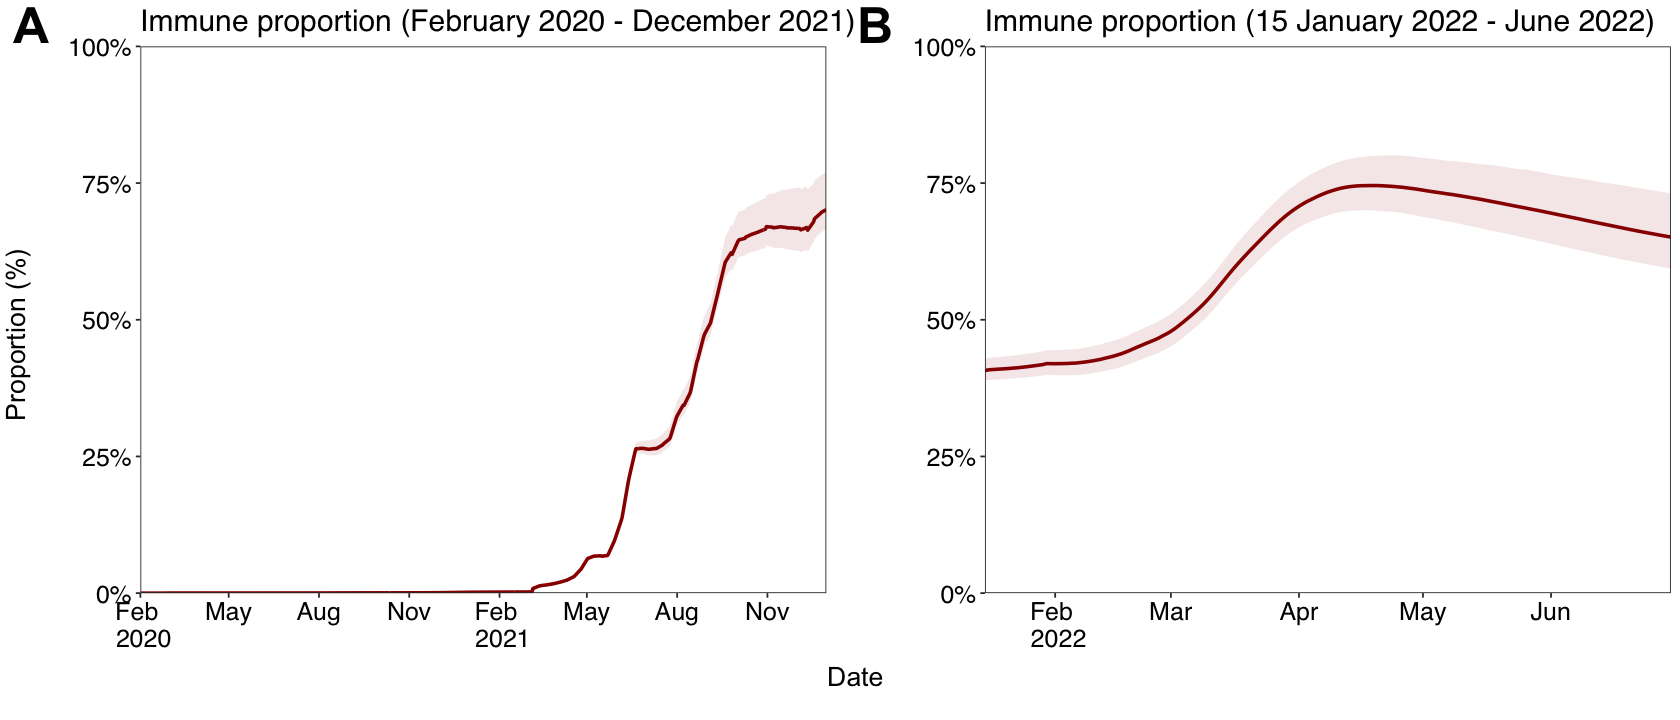

In [24]:
options(repr.plot.width=14,repr.plot.height=6)
ggarrange(fig_immune1, ggplot() + theme_void(), fig_immune2, nrow=1, widths = c(1, 0.05, 1), 
          labels = c("A", "", "B"), font.label = list(size = 30), vjust=1.2, hjust=0.5) -> Fig_immune

annotate_figure(Fig_immune, 
                left=text_grob("Proportion (%)", size=16, rot=90, hjust=0.35),
                bottom=text_grob("Date", size=16, vjust=-1)) -> Fig_immune_combined

Fig_immune_combined
ggsave("../figures/Final figures/Fig_S2.png", width = 14, height = 6, dpi=300, bg="white")
options(warn=0)